In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
import os
for root, dirs, files in os.walk("/kaggle/input/telco-customer-churn-11-1-3"):
    for f in files:
        print(f)


telco.csv


In [3]:
CSV_PATH = "/kaggle/input/telco-customer-churn-11-1-3/telco.csv"
df = pd.read_csv(CSV_PATH)
df.head()


,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,20,0.00,59.65,3,Churned,Yes,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,0,390.80,1024.10,3,Churned,Yes,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,...,0,203.94,1910.88,2,Churned,Yes,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,United States,California,...,0,494.00,2995.07,2,Churned,Yes,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,United States,California,...,0,234.21,3102.36,2,Churned,Yes,67,2793,Price,Extra data charges


In [4]:
# standardize column names
df.columns = df.columns.str.strip()

# rename churn column to simple one
df = df.rename(columns={'Churn Label':'Churn'})

# binary churn flag
df['Churn_Flag'] = (df['Churn'] == 'Yes').astype(int)

df.head()


,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn,Churn Score,CLTV,Churn Category,Churn Reason,Churn_Flag
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,0.00,59.65,3,Churned,Yes,91,5433,Competitor,Competitor offered more data,1
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,390.80,1024.10,3,Churned,Yes,69,5302,Competitor,Competitor made better offer,1
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,...,203.94,1910.88,2,Churned,Yes,81,3179,Competitor,Competitor made better offer,1
3,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,United States,California,...,494.00,2995.07,2,Churned,Yes,88,5337,Dissatisfaction,Limited range of services,1
4,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,United States,California,...,234.21,3102.36,2,Churned,Yes,67,2793,Price,Extra data charges,1


In [5]:
import sqlite3
conn = sqlite3.connect(':memory:')
df.to_sql('telco', conn, index=False, if_exists='replace')

def sql(q):
    return pd.read_sql_query(q, conn)


In [6]:
sql("SELECT Churn, COUNT(*) AS cnt FROM telco GROUP BY Churn;")


,Churn,cnt
0,No,5174
1,Yes,1869


In [7]:
sql("SELECT Churn, COUNT(*) AS cnt FROM telco GROUP BY Churn;")


,Churn,cnt
0,No,5174
1,Yes,1869


In [8]:
sql("""
SELECT [Churn Category],
       COUNT(*) AS customers,
       ROUND(AVG(CAST(Churn_Flag AS FLOAT))*100,2) AS churn_pct
FROM telco
GROUP BY [Churn Category]
ORDER BY churn_pct DESC;
""")


,Churn Category,customers,churn_pct
0,Price,211,100.0
1,Other,200,100.0
2,Dissatisfaction,303,100.0
3,Competitor,841,100.0
4,Attitude,314,100.0
5,None,5174,0.0


In [9]:
sql("""
SELECT Contract,
       COUNT(*) AS customers,
       ROUND(AVG(CAST(Churn_Flag AS FLOAT))*100,2) AS churn_pct
FROM telco
GROUP BY Contract
ORDER BY churn_pct DESC;
""")


,Contract,customers,churn_pct
0,Month-to-Month,3610,45.84
1,One Year,1550,10.71
2,Two Year,1883,2.55


In [10]:
sql("""
SELECT State,
       COUNT(*) AS customers,
       ROUND(AVG(CAST(Churn_Flag AS FLOAT))*100,2) AS churn_pct
FROM telco
GROUP BY State
ORDER BY churn_pct DESC
LIMIT 10;
""")


,State,customers,churn_pct
0,California,7043,26.54


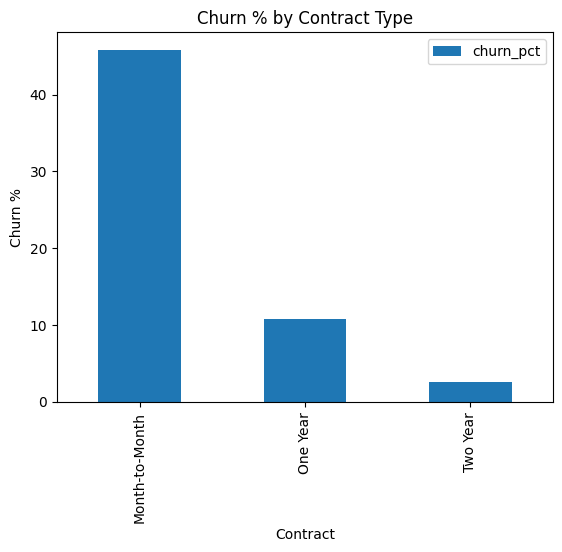

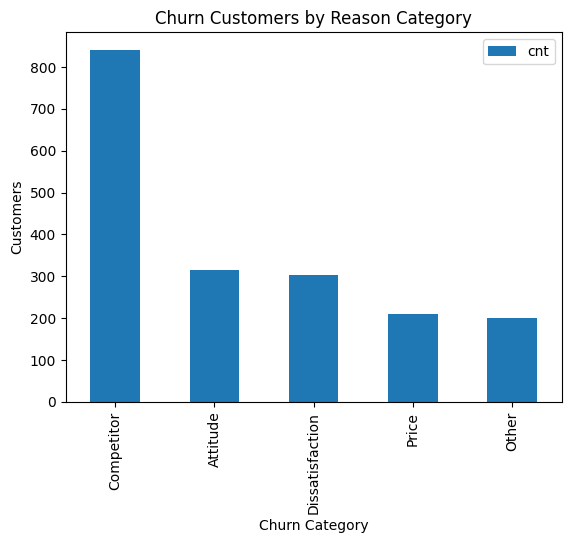

,Churn Reason,cnt
0,Competitor had better devices,313
1,Competitor made better offer,311
2,Attitude of support person,220
3,Don't know,130
4,Competitor offered more data,117
5,Competitor offered higher download speeds,100
6,Attitude of service provider,94
7,Price too high,78
8,Product dissatisfaction,77
9,Network reliability,72


In [11]:
# 1) churn by contract
contract = sql("""
SELECT Contract, ROUND(AVG(CAST(Churn_Flag AS FLOAT))*100,2) AS churn_pct
FROM telco GROUP BY Contract ORDER BY churn_pct DESC;
""")
contract.set_index('Contract').plot(kind='bar')
plt.title("Churn % by Contract Type")
plt.ylabel("Churn %")
plt.show()

# 2) churn reason count bar
reason = sql("""
SELECT [Churn Category], COUNT(*) AS cnt
FROM telco
WHERE Churn_Flag = 1
GROUP BY [Churn Category]
ORDER BY cnt DESC;
""")
reason.set_index('Churn Category').plot(kind='bar')
plt.title("Churn Customers by Reason Category")
plt.ylabel("Customers")
plt.show()

# 3) churn reason detail table
sql("SELECT [Churn Reason], COUNT(*) AS cnt FROM telco WHERE Churn_Flag=1 GROUP BY [Churn Reason] ORDER BY cnt DESC LIMIT 10;")


## Key Business Insights

- Month-to-Month customers churn **45.8%** → this is the #1 risky segment.
- Most churners leave to **Competitor** → direct pricing competition.
- **Price sensitivity** and **Service dissatisfaction** are major drivers.
- Annual contracts (Two year) have **2.5% churn** → lock-in works.
- Churn is mainly in **California** → local market competitive pressure.

## Recommendations

1) Convert month-to-month to 1-year plan → offer 2 months discount.
2) Launch competitor match plan (₹100 flat discount for 3 months).
3) Upgrade customer support SLAs (24h callback promise).
4) Introduce loyalty points for long-tenure users.
5) Price based segmentation → smart retention offers for high ARPU users.
